In [1]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import csv
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report 
import seaborn as sns

Setting up GPU acceleration

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 4090


In [3]:
# Setting up Data dir
data_dir = './data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')



In [4]:
classes = {key:value for value, key in datasets.ImageFolder(train_dir).class_to_idx.items()}
classes

{0: 'diseased leaf', 1: 'fresh leaf'}

In [5]:
# Data transformations & augmentations

DIM_SIZE = 256 
IMAGE_SIZE = 224
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE), # Crops the center region to a size of 224 x 224 pixels
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(DIM_SIZE), # Resizes the shorter side of image to 256 pixels while maintaining the aspect ratio.
        transforms.CenterCrop(IMAGE_SIZE), # Crops the center region to a size of 224 x 224 pixels
        transforms.ToTensor(),
        transforms.Normalize(mean, std)

    ]),
    'test': transforms.Compose([
        transforms.Resize(DIM_SIZE), # Resizes the shorter side of image to 256 pixels while maintaining the aspect ratio.
        transforms.CenterCrop(IMAGE_SIZE), # Crops the center region to a size of 224 x 224 pixels, 
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

After applying these transformations, all images (whether in training, validation, or testing) are resized to a uniform size of 224 x 224 pixels.

In [6]:
# Creating datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

In [7]:
# load Data using DataLoader class
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
# Lets check the sahpe of out tensors after the transformations:
for image, label in train_loader:
    break
print(f"Train Image Shape: {image.shape}, Train Label Shape:{label.shape}")
for image, label in val_loader:
    break
print(f"Val Image Shape: {image.shape}, Val Label Shape:{label.shape}")
for image, label in test_loader:
    break
print(f"Test Image Shape: {image.shape}, Test Label Shape:{label.shape}")

Train Image Shape: torch.Size([32, 3, 224, 224]), Train Label Shape:torch.Size([32])
Val Image Shape: torch.Size([32, 3, 224, 224]), Val Label Shape:torch.Size([32])
Test Image Shape: torch.Size([8, 3, 224, 224]), Test Label Shape:torch.Size([8])


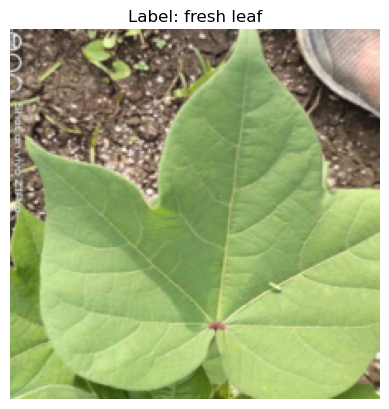

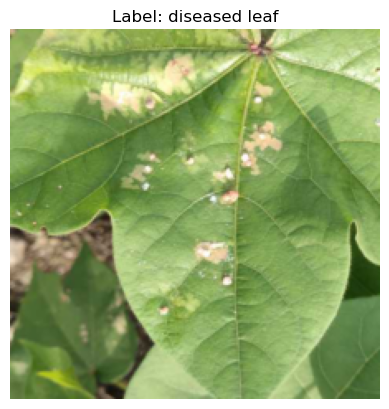

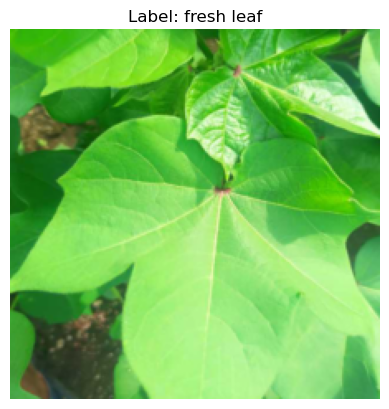

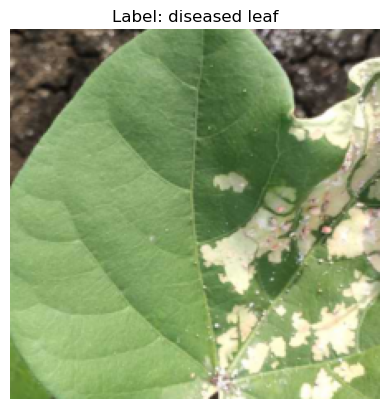

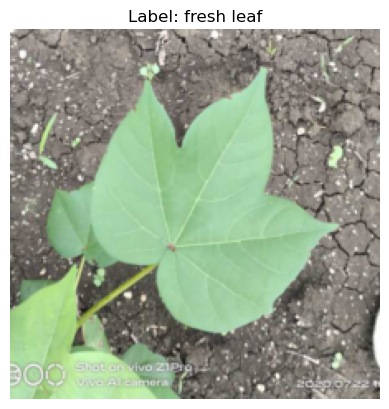

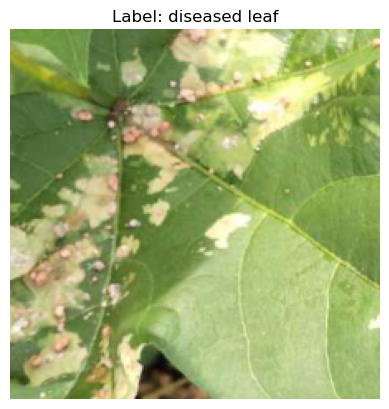

In [9]:
def show_images(images, labels, class_names):
    images = images.numpy().transpose((0, 2, 3, 1))  # Change shape from (batch_size, Channels, Height, Width) to (batch_size, Height, Width, Channels) for matplotlib 
    images = std * images + mean  # Denormalize 
    images = np.clip(images, 0, 1) # ensures that all pixel values in the images array are constrained within the range [0, 1]

    for i in range(len(images)):
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')
        plt.show()
        if i == 5:
            break # stop printing images after the ith image


images, labels = next(iter(train_loader)) # get a batch of images and their labels 
class_names = train_dataset.classes
show_images(images, labels, class_names)


In [10]:
# Classification CNN model with batch normalization from scratch ----> Base Model
class CNN_batch(nn.Module):
    def __init__(self, in_channels=3, out_1=16, out_2=32, number_of_classes=2):
        super(CNN_batch, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_2 * 56 * 56, number_of_classes)  # input Image: 224x224, After self.maxpool1: 224 / 2 = 112 After self.maxpool2: 112 / 2 = 56 So, the feature map size is 56x56 after two max-pooling layers.


    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layer

        x = self.fc1(x)

        return x 

In [11]:
# Classification CNN model with batch normalization from scratch ----> Base Model
class CNN_batch(nn.Module):
    def __init__(self, in_channels=3, out_1=16, out_2=32, number_of_classes=2):
        super(CNN_batch, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_2 * 56 * 56, number_of_classes)  # input Image: 224x224, After self.maxpool1: 224 / 2 = 112 After self.maxpool2: 112 / 2 = 56 So, the feature map size is 56x56 after two max-pooling layers.


    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layer

        x = self.fc1(x)

        return x 

In [12]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0 
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs,1)
        total+=labels.size(0)
        correct += torch.sum(predicted == labels).item()
    
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    return train_loss, train_accuracy



In [13]:
def eval_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            outputs= model(inputs)
            loss = criterion(outputs, labels)


            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels).item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct /total

    return val_loss, val_accuracy

In [14]:
model = CNN_batch(in_channels=3, out_1=16, out_2=32, number_of_classes=2)
model.to(DEVICE)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
# Lets implement Early Stopping

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0, verbose=False):
        self.patience=patience
        self.min_delta=min_delta
        self.counter=0
        self.min_val_loss = float('inf')
        self.verbose = verbose

    def early_stop(self, val_loss):
        if val_loss < self.min_val_loss:
            if self.verbose:
                print(f"Validation loss improved from {self.min_val_loss:.4f} to {val_loss:.4}")
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter+=1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                return True
        return False 

In [16]:
#  csv logger
class CSVLogger:
    def __init__(self, filename='training_log.csv'):
        self.filename=filename
        with open(self.filename, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy'])

    def log(self, epoch, train_loss, val_loss, train_accuracy, val_accuracy):
        with open(self.filename, mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([epoch, train_loss, val_loss, train_accuracy, val_accuracy])

In [19]:
# implement a ReduceLROnPlateau scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6)

# Initialize the callbacks
early_stopper = EarlyStopper(patience=5, min_delta=0.001)
csv_logger = CSVLogger(filename='training_log.csv')
num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = np.Inf

for epochs in range(num_epochs):

    train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer)

    val_loss, val_accuracy = eval_model(model, val_loader, criterion)

    csv_logger.log(epochs, train_loss, val_loss, train_accuracy, val_accuracy)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if early_stopper.early_stop(val_loss):
        print(f"Early stopping at epoch {epochs + 1}")
        break

    # Creating a checkpoint to save the best model 
    if val_loss < best_val_loss:
        torch.save({
            'epoch': epochs + 1,
            'state_dict': model.state_dict(),
            'best_val_loss': best_val_loss,
            'optimizer': optimizer.state_dict(),
        }, 'best_model.pt')
        
        print("Best model saved")
        best_val_loss = val_loss

    scheduler.step(val_loss)

    current_lr = scheduler.get_last_lr()[0]


    print(f"Epoch: [{epochs + 1} / {num_epochs}] | ' "
          f'Train Loss: {train_accuracy:.4f} | Train Accuracy: {train_accuracy:.4f} | ' 
          f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')
    print(f"Current Learning Rate: {current_lr:.6f}")

Best model saved
Epoch: [1 / 10] | ' Train Loss: 0.7203 | Train Accuracy: 0.7203 | Val Loss: 1.9501 | Val Accuracy: 0.7704
Current Learning Rate: 0.001000
Best model saved
Epoch: [2 / 10] | ' Train Loss: 0.7399 | Train Accuracy: 0.7399 | Val Loss: 0.7099 | Val Accuracy: 0.8444
Current Learning Rate: 0.001000
Best model saved
Epoch: [3 / 10] | ' Train Loss: 0.8448 | Train Accuracy: 0.8448 | Val Loss: 0.3213 | Val Accuracy: 0.8815
Current Learning Rate: 0.001000
Epoch: [4 / 10] | ' Train Loss: 0.7706 | Train Accuracy: 0.7706 | Val Loss: 2.5453 | Val Accuracy: 0.4963
Current Learning Rate: 0.001000
Epoch: [5 / 10] | ' Train Loss: 0.8252 | Train Accuracy: 0.8252 | Val Loss: 0.4082 | Val Accuracy: 0.9333
Current Learning Rate: 0.001000
Epoch: [6 / 10] | ' Train Loss: 0.8392 | Train Accuracy: 0.8392 | Val Loss: 0.4478 | Val Accuracy: 0.8815
Current Learning Rate: 0.000100
Best model saved
Epoch: [7 / 10] | ' Train Loss: 0.8797 | Train Accuracy: 0.8797 | Val Loss: 0.2274 | Val Accuracy: 0.933

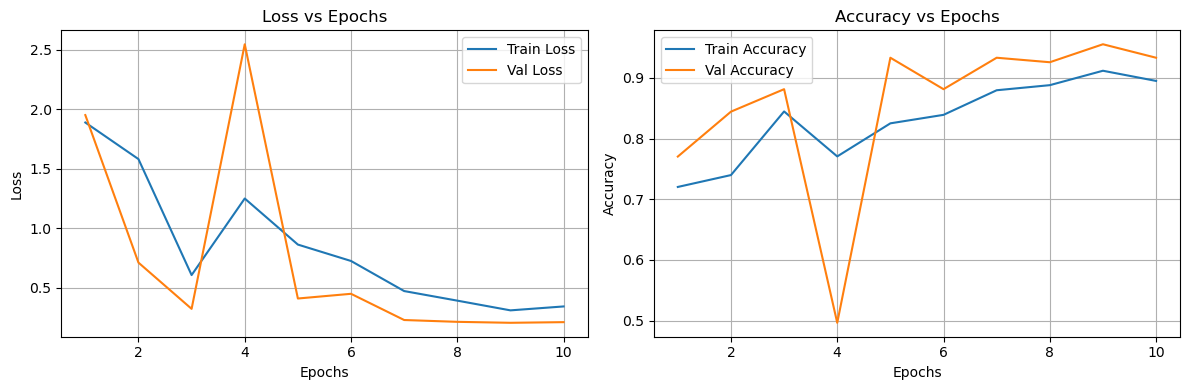

In [20]:
# Check the actual number of epochs completed
epochs_completed = len(train_losses)

# Set up the figure
plt.figure(figsize=(12, 4))

# Plot Loss vs. Epochs
plt.subplot(1, 2, 1)
plt.title("Loss vs Epochs")
plt.plot(range(1, epochs_completed + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs_completed + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.title('Accuracy vs Epochs')
plt.plot(range(1, epochs_completed + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs_completed + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [22]:
best_model = CNN_batch(in_channels=3, out_1=16, out_2=32, number_of_classes=2)
best_model.to(DEVICE)
checkpoint = torch.load('./best_model.pt', weights_only=True)
best_model.load_state_dict(checkpoint['state_dict'])

best_model.eval()



CNN_batch(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=2, bias=True)
)

In [23]:
def evaluate_test_set(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_preds = np.array(all_labels)

    return all_preds, all_labels

Test Accuracy: 1.0000
Precision score: 1.0000
Recall Score: 1.0000
Classification Report
               precision    recall  f1-score   support

diseased leaf       1.00      1.00      1.00         3
   fresh leaf       1.00      1.00      1.00         5

     accuracy                           1.00         8
    macro avg       1.00      1.00      1.00         8
 weighted avg       1.00      1.00      1.00         8



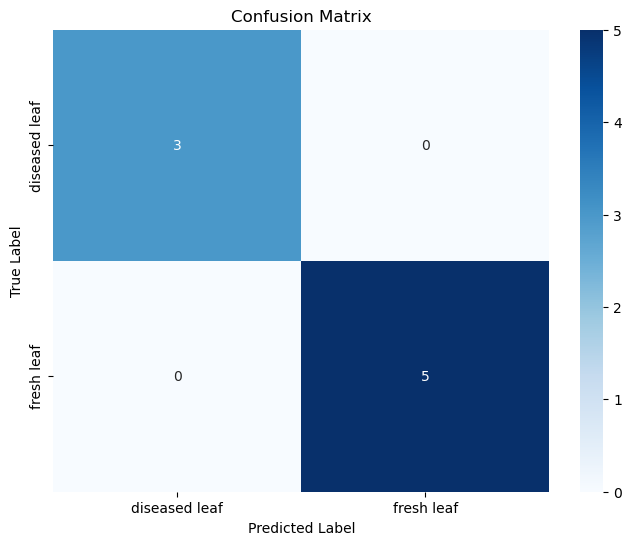

In [24]:
all_preds, all_labels = evaluate_test_set(best_model, test_loader)

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
print(f"Precision score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")

print("Classification Report")
print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes))

plt.figure(figsize=(8,6))

conf_matrix = confusion_matrix(all_labels, all_preds)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
def calculate_accuracy(loader, model, device=DEVICE):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

val_accuracy = calculate_accuracy(val_loader, best_model)
test_accuracy = calculate_accuracy(test_loader, best_model)

print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Validation Accuracy: 95.56%
Test Accuracy: 100.00%


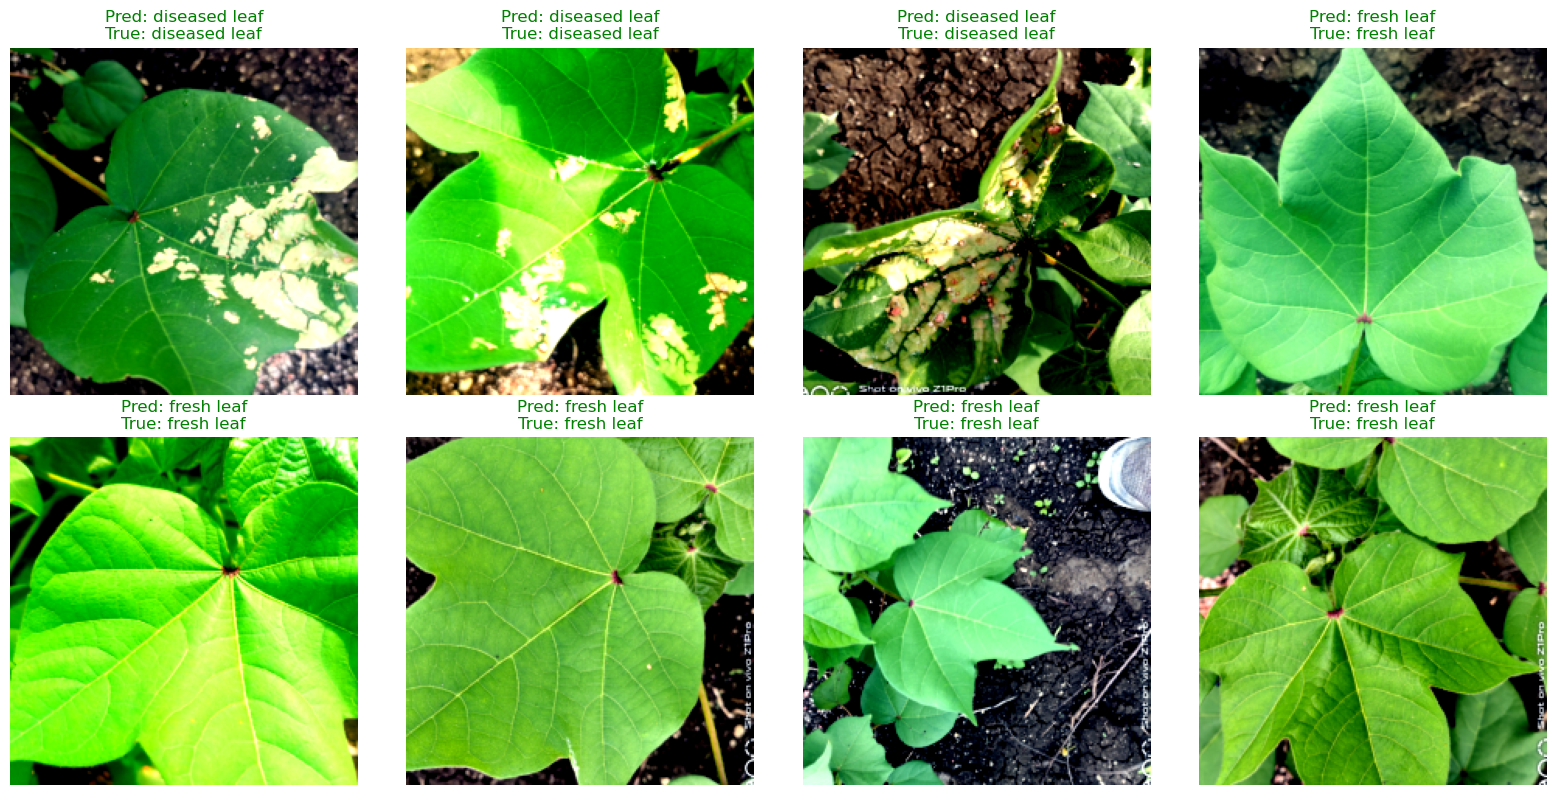

In [26]:
def visualize_predictions(model, data_loader, class_names, num_images=8):

    model.eval()
    images_shown = 0  # Counter for images displayed
    
    # Get a batch of data
    images, labels = next(iter(data_loader))
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Move data to CPU for visualization
    images = images.cpu()
    preds = preds.cpu()
    labels = labels.cpu()

    # Plot images in a grid
    plt.figure(figsize=(16, 8))
    
    for i in range(num_images):
        if images_shown >= num_images:
            break
        
        ax = plt.subplot(2, num_images//2, images_shown + 1)
        img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        
        # Denormalize the image (if normalization was used during preprocessing)
        img = img * mean + std
        img = np.clip(img, 0, 1)  # Clip values to ensure valid range [0, 1]
        
        plt.imshow(img)
        pred_class = class_names[preds[i]]
        true_class = class_names[labels[i]]
        
        # Set the title with predicted and true class labels
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}", color=("green" if pred_class == true_class else "red"), fontsize=12)
        plt.axis('off')  # Turn off the axis
        images_shown += 1
    
    plt.tight_layout()
    plt.show()


class_names = test_loader.dataset.classes  
visualize_predictions(best_model, test_loader, class_names, num_images=8)
